
# Montar las carpetas de google drive.
# Create environment in Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Move to google drive environment
%cd /content/drive/MyDrive/TFM Comparativa Soluciones

/content/drive/MyDrive/TFM Comparativa Soluciones


# Funciones para ejecutar el código

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from skimage import io

#!pip install efficientnet_pytorch torchtoolbox
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
#import torchtoolbox.transform as transforms

import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import gc
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

from PIL import Image
from IPython.display import FileLink 

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def make_CNN(model_name, num_classes):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    elif model_name == "vgg16":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, 1)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    else:
        raise Exception("Invalid model name!")
    
    return model_ft, input_size

In [ ]:
class Melanoma_Net(nn.Module):
    """
    fc1: number of neurons in the hidden fully connected layer
    """
    def __init__(self, cnn_model_name, num_classes, num_multimodal_features=9, fc1_out=32):
        #num_classes = 1
        #num_multimodal_features= 9
        super(Melanoma_Net, self).__init__()
        self.cnn, self.input_size = make_CNN(cnn_model_name, num_classes)#models.vgg11(pretrained=False, progress = True)
        #define output layers
        self.fc1 = nn.Linear(num_classes + num_multimodal_features, fc1_out) #takes in input of CNN and multimodal input
        self.fc2 = nn.Linear(fc1_out, num_classes)
        
    def forward(self, image, data):
        x1 = self.cnn(image)
        #print("x1", x1.shape)
        x2 = data
        #print("x2", x2.shape)
        #print("x1: ", x1, type(x1))
        #print("x2: ", x2, type(x2))
        #x = torch.cat((x1, x2), dim=1)  
        x = torch.cat((x1.float(), x2.float()), dim=1) ### ???

        #print("concat", x.shape)
        x = F.relu(self.fc1(x))
        #print("relu", x.shape)
        x = self.fc2(x)
        #print('forward output: ', x)
        #print("fc2", x.shape)
        return x.double() ### ???

In [ ]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img_path):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        img = cv2.imread(img_path)
        n_hairs = random.randint(1, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converts image color back to regular color (instead of producing blue tinted image)        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [ ]:
class MultimodalDataset(Dataset):
    """
    Custom dataset definition
    """
    def __init__(self, csv_path, img_path, mode='train', transform=None):
        """
        """
        self.df = pd.read_csv(csv_path)
        self.img_path = img_path
        self.mode= mode
        self.transform = transform
        
            
    def __getitem__(self, index):
        """
        """
        img_name = self.df.iloc[index]["image_name"] + ".jpg"
        img_path = os.path.join(self.img_path, img_name)
        image = Image.open(img_path)

        dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor # ???
        
        if self.mode == 'train':
            #augments malignant images with hair twice
            if self.df.iloc[index]["augmented"]==1:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            elif self.df.iloc[index]["augmented"]==2:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            else:  
                image = image.convert("RGB")
                
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array            
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
            
        elif self.mode == 'val':
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
        
        else: #when self.mode=='test'
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, self.df.iloc[index]["image_name"]

    def __len__(self):
        return len(self.df)

In [ ]:
image_path_dict = {'train': "train",
                  'val': "train" ,
                  'test': "train"}

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [ ]:
def make_optimizer(model):
    #Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    #Use SGD
    optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
    return optimizer

 
def get_loss(num_classes,device):
    # Create an instance of the loss function
    # We could set weights to account for unbalanced data but we have augmented the data to be even in benign count and malignant count
    
    #pos_weight = torch.tensor(np.ones(num_classes))
    #pos_weight = pos_weight.to(device)
    criterion = nn.BCEWithLogitsLoss()
    
    #criterion = FocalLoss()
    return criterion

In [ ]:
def get_dataloaders(input_size, batch_size, augment=False, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    data_transforms = {
        'train': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ])
    }
    # Create training and validation datasets
    data_subsets = {x: MultimodalDataset(csv_path="melanoma_without_duplicates_separated/" + x + ".csv", 
                                         img_path = image_path_dict[x],
                                         mode = x,
                                         transform=data_transforms[x]) for x in data_transforms.keys()}
    
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: DataLoader(data_subsets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

In [ ]:
val_df = pd.read_csv("melanoma_without_duplicates_separated/val.csv")
val_real = []
for i in range(val_df.shape[0]):
    val_real.append(val_df['target'].iloc[i])

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, 
                scheduler, model_name=str(datetime.datetime.now()), 
                save_dir = None, num_epochs=25):
    import time
    start_time = time.time()
    
    #take out if just starting to train
    #checkpoint = torch.load("../input/shuffle-meta-conf-matrix/resnet_weights_12.pt")
    #model.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    #epoch_before = checkpoint['epoch']

    train_losses = []
    test_losses = []
    train_auc=[]
    val_auc=[]
    train_pred = []
    train_real = []
    val_pred = []
    val_real = []
    for epoch in range(num_epochs):

        train_preds=[]
        train_targets=[]
        auc_train=[]
        loss_epoch_train=[]
        loss_epoch_test=[]
        # Run the training batches
        for inputs, features, labels in tqdm(dataloaders['train']):
            inputs = inputs.to(device)
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs, features)
            outputs = torch.squeeze(outputs)
            #outputs = torch.as_tensor(outputs.tolist())
            preds = (outputs > 0).type(torch.float64)
            train_real.extend(labels.tolist())
            train_pred.extend(preds.tolist())
            
            labels = torch.squeeze(labels)
            loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
            loss_epoch_train.append(loss.item())
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        auc_train=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        #auc_train=roc_auc_score(y_train.detach().to(device).numpy(),torch.sigmoid(y_pred).detach().to(device).numpy())
        
        train_losses.append(np.mean(loss_epoch_train))
        train_auc.append(auc_train)
        
        print(f'Epoch: {epoch:2} Train Loss: {np.mean(loss_epoch_train):10.8f} AUC: {auc_train:10.8f} ')
        df_confusion = confusion_matrix(train_real, train_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        # Run the testing batches
        with torch.no_grad():
            for inputs, features, labels in tqdm(dataloaders['val']):
                inputs = inputs.to(device)
                features = features.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs, features)
                #print('outputs1 ' + str(outputs))

                outputs = torch.squeeze(outputs)
                #print('outputs2 ' + str(outputs))
                preds = (outputs > 0).type(torch.float64)
                #print('labels ' + (str(labels)))
                #print('pred ' + str(preds))
                val_real.extend(labels.tolist())
                val_pred.extend(preds.tolist())
                
                #outputs = torch.as_tensor(outputs.tolist())
                #print('new outs', outputs)
                labels = torch.squeeze(labels)
                loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
                loss_epoch_test.append(loss.item())
                                          
        auc_val=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        
        test_losses.append(np.mean(loss_epoch_test))
        val_auc.append(auc_val)
        
        print(f'Epoch: {epoch} Val Loss: {np.mean(loss_epoch_test):10.8f} AUC: {auc_val:10.8f} ')
        df_confusion = confusion_matrix(val_real, val_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        if epoch % 5==0:
        #if epoch % 5==0:
            model_file = { 'epoch': epoch,
                      'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}
            torch.save(model_file, "melanoma_without_duplicates_separated/Pesos Resnet 20/{}_weights_{}.pt".format(model_name, epoch))
        #epoch if just started training
        #epoch + epoch_before + 1 afterwards
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed
    return train_auc, val_auc, train_losses,test_losses

In [ ]:
# Models to choose from [resnet, vgg16, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = 'resnet'

# Number of classes in the dataset
num_classes = 1

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 64

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 200

# Directory to save weights to
#save_dir = "weights"
#os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Initialize the model for this run
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes)
input_size = model.input_size
    
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets)
criterion = get_loss(num_classes=num_classes,device=device)

# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10],gamma=0.1)

# Train the model!
train_auc, val_auc,train_losses,test_losses  = train_model(model=model,
            dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
            scheduler=scheduler, model_name=model_name, num_epochs=num_epochs)

Params to learn:
	 cnn.conv1.weight
	 cnn.bn1.weight
	 cnn.bn1.bias
	 cnn.layer1.0.conv1.weight
	 cnn.layer1.0.bn1.weight
	 cnn.layer1.0.bn1.bias
	 cnn.layer1.0.conv2.weight
	 cnn.layer1.0.bn2.weight
	 cnn.layer1.0.bn2.bias
	 cnn.layer1.1.conv1.weight
	 cnn.layer1.1.bn1.weight
	 cnn.layer1.1.bn1.bias
	 cnn.layer1.1.conv2.weight
	 cnn.layer1.1.bn2.weight
	 cnn.layer1.1.bn2.bias
	 cnn.layer2.0.conv1.weight
	 cnn.layer2.0.bn1.weight
	 cnn.layer2.0.bn1.bias
	 cnn.layer2.0.conv2.weight
	 cnn.layer2.0.bn2.weight
	 cnn.layer2.0.bn2.bias
	 cnn.layer2.0.downsample.0.weight
	 cnn.layer2.0.downsample.1.weight
	 cnn.layer2.0.downsample.1.bias
	 cnn.layer2.1.conv1.weight
	 cnn.layer2.1.bn1.weight
	 cnn.layer2.1.bn1.bias
	 cnn.layer2.1.conv2.weight
	 cnn.layer2.1.bn2.weight
	 cnn.layer2.1.bn2.bias
	 cnn.layer3.0.conv1.weight
	 cnn.layer3.0.bn1.weight
	 cnn.layer3.0.bn1.bias
	 cnn.layer3.0.conv2.weight
	 cnn.layer3.0.bn2.weight
	 cnn.layer3.0.bn2.bias
	 cnn.layer3.0.downsample.0.weight
	 cnn.layer3.0

100%|██████████| 27/27 [03:11<00:00,  7.11s/it]


Epoch:  0 Train Loss: 0.73399290 AUC: 0.79149798 
[[0.08568207 0.91431793]
 [0.03686088 0.96313912]]


100%|██████████| 7/7 [00:58<00:00,  8.40s/it]


Epoch: 0 Val Loss: 0.73210282 AUC: 0.71157495 
[[0.37387387 0.62612613]
 [0.2        0.8       ]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch:  1 Train Loss: 0.72262522 AUC: 0.82769231 
[[0.45039459 0.54960541]
 [0.26456599 0.73543401]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 1 Val Loss: 0.72168092 AUC: 0.74762808 
[[0.64189189 0.35810811]
 [0.49285714 0.50714286]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch:  2 Train Loss: 0.70074158 AUC: 0.81036168 
[[0.61518226 0.38481774]
 [0.38287753 0.61712247]]


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 2 Val Loss: 0.69781721 AUC: 0.72296015 
[[0.72222222 0.27777778]
 [0.56825397 0.43174603]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch:  3 Train Loss: 0.65318772 AUC: 0.83743842 
[[0.68742954 0.31257046]
 [0.40368609 0.59631391]]


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch: 3 Val Loss: 0.66727702 AUC: 0.72675522 
[[0.74211712 0.25788288]
 [0.56547619 0.43452381]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch:  4 Train Loss: 0.62188136 AUC: 0.80175781 
[[0.7253664  0.2746336 ]
 [0.39310345 0.60689655]]


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch: 4 Val Loss: 0.65884257 AUC: 0.72296015 
[[0.74144144 0.25855856]
 [0.52095238 0.47904762]]


100%|██████████| 27/27 [00:12<00:00,  2.25it/s]


Epoch:  5 Train Loss: 0.61349054 AUC: 0.85728250 
[[0.74765126 0.25234874]
 [0.37792311 0.62207689]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 5 Val Loss: 0.65336785 AUC: 0.80075901 
[[0.74324324 0.25675676]
 [0.49761905 0.50238095]]


100%|██████████| 27/27 [00:12<00:00,  2.17it/s]


Epoch:  6 Train Loss: 0.61033312 AUC: 0.83431373 
[[0.76260267 0.23739733]
 [0.36589095 0.63410905]]


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 6 Val Loss: 0.64795298 AUC: 0.82163188 
[[0.74839125 0.25160875]
 [0.47755102 0.52244898]]


100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Epoch:  7 Train Loss: 0.61227665 AUC: 0.90784314 
[[0.77212514 0.22787486]
 [0.3544887  0.6455113 ]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 7 Val Loss: 0.64907088 AUC: 0.76660342 
[[0.7454955  0.2545045 ]
 [0.45297619 0.54702381]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch:  8 Train Loss: 0.61260975 AUC: 0.87292278 
[[0.77978204 0.22021796]
 [0.34839477 0.65160523]]


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch: 8 Val Loss: 0.65399203 AUC: 0.74003795 
[[0.74724725 0.25275275]
 [0.44126984 0.55873016]]


100%|██████████| 27/27 [00:11<00:00,  2.25it/s]


Epoch:  9 Train Loss: 0.60563447 AUC: 0.92092092 
[[0.78748591 0.21251409]
 [0.34078478 0.65921522]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 9 Val Loss: 0.66663622 AUC: 0.77039848 
[[0.74459459 0.25540541]
 [0.43666667 0.56333333]]


100%|██████████| 27/27 [00:12<00:00,  2.19it/s]


Epoch: 10 Train Loss: 0.61791788 AUC: 0.86896552 
[[0.78999693 0.21000307]
 [0.335207   0.664793  ]]


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch: 10 Val Loss: 0.65745842 AUC: 0.74193548 
[[0.74897625 0.25102375]
 [0.43636364 0.56363636]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 11 Train Loss: 0.60662342 AUC: 0.89705882 
[[0.79481398 0.20518602]
 [0.33026159 0.66973841]]


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 11 Val Loss: 0.65625443 AUC: 0.76660342 
[[0.74962462 0.25037538]
 [0.43134921 0.56865079]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 12 Train Loss: 0.60251845 AUC: 0.89980159 
[[0.80131819 0.19868181]
 [0.3279978  0.6720022 ]]


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch: 12 Val Loss: 0.64173878 AUC: 0.80834915 
[[0.75225225 0.24774775]
 [0.42417582 0.57582418]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 13 Train Loss: 0.59913825 AUC: 0.85047720 
[[0.80616847 0.19383153]
 [0.32325463 0.67674537]]


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch: 13 Val Loss: 0.64535222 AUC: 0.85009488 
[[0.7545045  0.2454955 ]
 [0.42040816 0.57959184]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 14 Train Loss: 0.59804138 AUC: 0.92675781 
[[0.81014656 0.18985344]
 [0.31874752 0.68125248]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 14 Val Loss: 0.64746463 AUC: 0.82163188 
[[0.75465465 0.24534535]
 [0.41587302 0.58412698]]


100%|██████████| 27/27 [00:11<00:00,  2.27it/s]


Epoch: 15 Train Loss: 0.59467572 AUC: 0.90773810 
[[0.81412063 0.18587937]
 [0.31435791 0.68564209]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 15 Val Loss: 0.65317124 AUC: 0.80834915 
[[0.75365991 0.24634009]
 [0.4110119  0.5889881 ]]


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Epoch: 16 Train Loss: 0.59742093 AUC: 0.86705767 
[[0.81689767 0.18310233]
 [0.31020494 0.68979506]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 16 Val Loss: 0.65314146 AUC: 0.84440228 
[[0.75198728 0.24801272]
 [0.40644258 0.59355742]]


100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Epoch: 17 Train Loss: 0.59420894 AUC: 0.92473118 
[[0.81999248 0.18000752]
 [0.30697582 0.69302418]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 17 Val Loss: 0.64470299 AUC: 0.78747628 
[[0.75075075 0.24924925]
 [0.3989418  0.6010582 ]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 18 Train Loss: 0.59272221 AUC: 0.92578125 
[[0.82394826 0.17605174]
 [0.30558859 0.69441141]]


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch: 18 Val Loss: 0.64477807 AUC: 0.82542694 
[[0.75106686 0.24893314]
 [0.39423559 0.60576441]]


100%|██████████| 27/27 [00:12<00:00,  2.25it/s]


Epoch: 19 Train Loss: 0.58879019 AUC: 0.85846154 
[[0.82790304 0.17209696]
 [0.30332937 0.69667063]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 19 Val Loss: 0.64986959 AUC: 0.83681214 
[[0.7509009  0.2490991 ]
 [0.39190476 0.60809524]]


100%|██████████| 27/27 [00:12<00:00,  2.25it/s]


Epoch: 20 Train Loss: 0.58994719 AUC: 0.90820312 
[[0.8299243  0.1700757 ]
 [0.29907706 0.70092294]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 20 Val Loss: 0.65490007 AUC: 0.82352941 
[[0.75075075 0.24924925]
 [0.39024943 0.60975057]]


100%|██████████| 27/27 [00:12<00:00,  2.18it/s]


Epoch: 21 Train Loss: 0.59126062 AUC: 0.87987988 
[[0.83201804 0.16798196]
 [0.29661658 0.70338342]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 21 Val Loss: 0.64536876 AUC: 0.81593928 
[[0.750819   0.249181  ]
 [0.38679654 0.61320346]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 22 Train Loss: 0.58771923 AUC: 0.91202346 
[[0.83437086 0.16562914]
 [0.29359458 0.70640542]]


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch: 22 Val Loss: 0.65089218 AUC: 0.81593928 
[[0.74892284 0.25107716]
 [0.38281573 0.61718427]]


100%|██████████| 27/27 [00:11<00:00,  2.25it/s]


Epoch: 23 Train Loss: 0.59457787 AUC: 0.94531250 
[[0.83695039 0.16304961]
 [0.29340071 0.70659929]]


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch: 23 Val Loss: 0.64765376 AUC: 0.80455408 
[[0.74906156 0.25093844]
 [0.37936508 0.62063492]]


100%|██████████| 27/27 [00:11<00:00,  2.25it/s]


Epoch: 24 Train Loss: 0.59080700 AUC: 0.88465298 
[[0.83959414 0.16040586]
 [0.29260404 0.70739596]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 24 Val Loss: 0.64898058 AUC: 0.78937381 
[[0.74972973 0.25027027]
 [0.37828571 0.62171429]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 25 Train Loss: 0.58388202 AUC: 0.93353175 
[[0.84233805 0.15766195]
 [0.29122839 0.70877161]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 25 Val Loss: 0.64542472 AUC: 0.82732448 
[[0.750693   0.249307  ]
 [0.37673993 0.62326007]]


100%|██████████| 27/27 [00:12<00:00,  2.16it/s]


Epoch: 26 Train Loss: 0.58888990 AUC: 0.88367546 
[[0.84416886 0.15583114]
 [0.29008676 0.70991324]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 26 Val Loss: 0.64227624 AUC: 0.86717268 
[[0.75008342 0.24991658]
 [0.37266314 0.62733686]]


100%|██████████| 27/27 [00:12<00:00,  2.25it/s]


Epoch: 27 Train Loss: 0.58580969 AUC: 0.93059629 
[[0.8464326  0.1535674 ]
 [0.28864447 0.71135553]]


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 27 Val Loss: 0.65847103 AUC: 0.81024668 
[[0.75032175 0.24967825]
 [0.37346939 0.62653061]]


100%|██████████| 27/27 [00:12<00:00,  2.25it/s]


Epoch: 28 Train Loss: 0.58926357 AUC: 0.92992993 
[[0.84857909 0.15142091]
 [0.2883267  0.7116733 ]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 28 Val Loss: 0.64231758 AUC: 0.90132827 
[[0.75038832 0.24961168]
 [0.37093596 0.62906404]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 29 Train Loss: 0.58823152 AUC: 0.87955466 
[[0.85009395 0.14990605]
 [0.2868807  0.7131193 ]]


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch: 29 Val Loss: 0.64674102 AUC: 0.85958254 
[[0.74864865 0.25135135]
 [0.36650794 0.63349206]]


100%|██████████| 27/27 [00:12<00:00,  2.18it/s]


Epoch: 30 Train Loss: 0.58600590 AUC: 0.91006843 
[[0.85111103 0.14888897]
 [0.28464577 0.71535423]]


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 30 Val Loss: 0.64142234 AUC: 0.81214421 
[[0.74818367 0.25181633]
 [0.36236559 0.63763441]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 31 Train Loss: 0.58594956 AUC: 0.93201970 
[[0.85195885 0.14804115]
 [0.28236474 0.71763526]]


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch: 31 Val Loss: 0.65464693 AUC: 0.78178368 
[[0.74746622 0.25253378]
 [0.36116071 0.63883929]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 32 Train Loss: 0.58548246 AUC: 0.93623482 
[[0.85337023 0.14662977]
 [0.28123086 0.71876914]]


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch: 32 Val Loss: 0.63521844 AUC: 0.91271347 
[[0.74815725 0.25184275]
 [0.35873016 0.64126984]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 33 Train Loss: 0.58297146 AUC: 0.94232649 
[[0.85449964 0.14550036]
 [0.27932433 0.72067567]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 33 Val Loss: 0.63868267 AUC: 0.86527514 
[[0.74986751 0.25013249]
 [0.35882353 0.64117647]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 34 Train Loss: 0.58843519 AUC: 0.93450635 
[[0.85598325 0.14401675]
 [0.27912349 0.72087651]]


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch: 34 Val Loss: 0.64001103 AUC: 0.85009488 
[[0.74954955 0.25045045]
 [0.35591837 0.64408163]]


100%|██████████| 27/27 [00:11<00:00,  2.30it/s]


Epoch: 35 Train Loss: 0.58048804 AUC: 0.93157380 
[[0.85769761 0.14230239]
 [0.27824019 0.72175981]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 35 Val Loss: 0.64446718 AUC: 0.87096774 
[[0.748999   0.251001  ]
 [0.35396825 0.64603175]]


100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Epoch: 36 Train Loss: 0.58192656 AUC: 0.96847291 
[[0.85904507 0.14095493]
 [0.27724395 0.72275605]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 36 Val Loss: 0.64668375 AUC: 0.87855787 
[[0.747626   0.252374  ]
 [0.35096525 0.64903475]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 37 Train Loss: 0.57855808 AUC: 0.94345238 
[[0.86014359 0.13985641]
 [0.27554916 0.72445084]]


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 37 Val Loss: 0.64416700 AUC: 0.83111954 
[[0.74774775 0.25225225]
 [0.34974937 0.65025063]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 38 Train Loss: 0.58071955 AUC: 0.90690691 
[[0.8612147  0.1387853 ]
 [0.27433763 0.72566237]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 38 Val Loss: 0.63877032 AUC: 0.85388994 
[[0.74867175 0.25132825]
 [0.34908425 0.65091575]]


100%|██████████| 27/27 [00:11<00:00,  2.30it/s]


Epoch: 39 Train Loss: 0.57323292 AUC: 0.89540567 
[[0.86257046 0.13742954]
 [0.27256243 0.72743757]]


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 39 Val Loss: 0.63780647 AUC: 0.88045541 
[[0.74954955 0.25045045]
 [0.34916667 0.65083333]]


100%|██████████| 27/27 [00:11<00:00,  2.26it/s]


Epoch: 40 Train Loss: 0.57559033 AUC: 0.96551724 
[[0.8638326  0.1361674 ]
 [0.27133784 0.72866216]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 40 Val Loss: 0.64894670 AUC: 0.85958254 
[[0.74818721 0.25181279]
 [0.34680604 0.65319396]]


100%|██████████| 27/27 [00:11<00:00,  2.25it/s]


Epoch: 41 Train Loss: 0.57589733 AUC: 0.95295295 
[[0.86490041 0.13509959]
 [0.26991677 0.73008323]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 41 Val Loss: 0.64421128 AUC: 0.84250474 
[[0.74753325 0.25246675]
 [0.3452381  0.6547619 ]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 42 Train Loss: 0.57200457 AUC: 0.87683284 
[[0.86610209 0.13389791]
 [0.26817465 0.73182535]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 42 Val Loss: 0.65463826 AUC: 0.85388994 
[[0.74617641 0.25382359]
 [0.34352159 0.65647841]]


100%|██████████| 27/27 [00:11<00:00,  2.29it/s]


Epoch: 43 Train Loss: 0.57346225 AUC: 0.87695312 
[[0.86737727 0.13262273]
 [0.26691709 0.73308291]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 43 Val Loss: 0.63771331 AUC: 0.89373814 
[[0.74641687 0.25358313]
 [0.34220779 0.65779221]]


100%|██████████| 27/27 [00:11<00:00,  2.30it/s]


Epoch: 44 Train Loss: 0.57317560 AUC: 0.89589590 
[[0.86849555 0.13150445]
 [0.26550403 0.73449597]]


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch: 44 Val Loss: 0.65393960 AUC: 0.79886148 
[[0.74604605 0.25395395]
 [0.34169312 0.65830688]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 45 Train Loss: 0.57516804 AUC: 0.92375367 
[[0.86966325 0.13033675]
 [0.26459184 0.73540816]]


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch: 45 Val Loss: 0.63525465 AUC: 0.90512334 
[[0.74676851 0.25323149]
 [0.34109731 0.65890269]]


100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Epoch: 46 Train Loss: 0.57522701 AUC: 0.91397849 
[[0.87037348 0.12962652]
 [0.26321249 0.73678751]]


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch: 46 Val Loss: 0.63944769 AUC: 0.86907021 
[[0.74698102 0.25301898]
 [0.34002026 0.65997974]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 47 Train Loss: 0.57513723 AUC: 0.94482759 
[[0.87135945 0.12864055]
 [0.26228696 0.73771304]]


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 47 Val Loss: 0.65168853 AUC: 0.75901328 
[[0.74831081 0.25168919]
 [0.34166667 0.65833333]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 48 Train Loss: 0.57591809 AUC: 0.85585586 
[[0.87242022 0.12757978]
 [0.26173894 0.73826106]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 48 Val Loss: 0.62959140 AUC: 0.83491461 
[[0.74912668 0.25087332]
 [0.34023324 0.65976676]]


100%|██████████| 27/27 [00:11<00:00,  2.26it/s]


Epoch: 49 Train Loss: 0.57389194 AUC: 0.88465298 
[[0.87328072 0.12671928]
 [0.26071344 0.73928656]]


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch: 49 Val Loss: 0.63247352 AUC: 0.89943074 
[[0.74900901 0.25099099]
 [0.33857143 0.66142857]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 50 Train Loss: 0.56985492 AUC: 0.94117647 
[[0.87452749 0.12547251]
 [0.25993798 0.74006202]]


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch: 50 Val Loss: 0.63665390 AUC: 0.85388994 
[[0.7490726  0.2509274 ]
 [0.33734827 0.66265173]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 51 Train Loss: 0.56560737 AUC: 0.89682540 
[[0.87566126 0.12433874]
 [0.25873502 0.74126498]]


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch: 51 Val Loss: 0.63539605 AUC: 0.85578748 
[[0.74878725 0.25121275]
 [0.33580586 0.66419414]]


100%|██████████| 27/27 [00:12<00:00,  2.19it/s]


Epoch: 52 Train Loss: 0.56353982 AUC: 0.93990148 
[[0.87673098 0.12326902]
 [0.25712876 0.74287124]]


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 52 Val Loss: 0.65010658 AUC: 0.81973435 
[[0.74834268 0.25165732]
 [0.33513028 0.66486972]]


100%|██████████| 27/27 [00:12<00:00,  2.19it/s]


Epoch: 53 Train Loss: 0.56608926 AUC: 0.95369458 
[[0.87771932 0.12228068]
 [0.25586823 0.74413177]]


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch: 53 Val Loss: 0.62899360 AUC: 0.92599620 
[[0.74891558 0.25108442]
 [0.33377425 0.66622575]]


100%|██████████| 27/27 [00:11<00:00,  2.25it/s]


Epoch: 54 Train Loss: 0.56333652 AUC: 0.95307918 
[[0.87863073 0.12136927]
 [0.25439412 0.74560588]]


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch: 54 Val Loss: 0.63208305 AUC: 0.88425047 
[[0.74938575 0.25061425]
 [0.33255411 0.66744589]]


100%|██████████| 27/27 [00:12<00:00,  2.16it/s]


Epoch: 55 Train Loss: 0.55961342 AUC: 0.98076923 
[[0.87975117 0.12024883]
 [0.25290895 0.74709105]]


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 55 Val Loss: 0.63986020 AUC: 0.83301708 
[[0.74887387 0.25112613]
 [0.33061224 0.66938776]]


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Epoch: 56 Train Loss: 0.55774086 AUC: 0.93724696 
[[0.88089163 0.11910837]
 [0.25141331 0.74858669]]


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch: 56 Val Loss: 0.63872833 AUC: 0.80834915 
[[0.74885412 0.25114588]
 [0.32965748 0.67034252]]


100%|██████████| 27/27 [00:12<00:00,  2.19it/s]


Epoch: 57 Train Loss: 0.56118380 AUC: 0.93235294 
[[0.88183727 0.11816273]
 [0.25015376 0.74984624]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 57 Val Loss: 0.63284963 AUC: 0.82922201 
[[0.74891271 0.25108729]
 [0.32791461 0.67208539]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 58 Train Loss: 0.56053923 AUC: 0.91345029 
[[0.88301836 0.11698164]
 [0.24917874 0.75082126]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 58 Val Loss: 0.63095597 AUC: 0.84629981 
[[0.74950374 0.25049626]
 [0.32744149 0.67255851]]


100%|██████████| 27/27 [00:12<00:00,  2.18it/s]


Epoch: 59 Train Loss: 0.56275776 AUC: 0.95898438 
[[0.88374671 0.11625329]
 [0.24785969 0.75214031]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 59 Val Loss: 0.63592067 AUC: 0.83681214 
[[0.75007508 0.24992492]
 [0.32714286 0.67285714]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 60 Train Loss: 0.56166002 AUC: 0.94444444 
[[0.88482082 0.11517918]
 [0.24705171 0.75294829]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 60 Val Loss: 0.62757232 AUC: 0.89943074 
[[0.75040614 0.24959386]
 [0.32599532 0.67400468]]


100%|██████████| 27/27 [00:14<00:00,  1.92it/s]


Epoch: 61 Train Loss: 0.55766191 AUC: 0.91796875 
[[0.88580572 0.11419428]
 [0.24584788 0.75415212]]


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch: 61 Val Loss: 0.62719614 AUC: 0.91271347 
[[0.75094449 0.24905551]
 [0.32511521 0.67488479]]


100%|██████████| 27/27 [00:11<00:00,  2.32it/s]


Epoch: 62 Train Loss: 0.55985602 AUC: 0.97142857 
[[0.88659831 0.11340169]
 [0.24458789 0.75541211]]


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 62 Val Loss: 0.63227178 AUC: 0.88804554 
[[0.75067925 0.24932075]
 [0.32365835 0.67634165]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 63 Train Loss: 0.55149139 AUC: 0.94894895 
[[0.88755989 0.11244011]
 [0.24295853 0.75704147]]


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch: 63 Val Loss: 0.62942252 AUC: 0.84060721 
[[0.75091498 0.24908502]
 [0.32224702 0.67775298]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 64 Train Loss: 0.54887992 AUC: 0.96945813 
[[0.8886133  0.1113867 ]
 [0.24134272 0.75865728]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 64 Val Loss: 0.62896001 AUC: 0.86907021 
[[0.75072765 0.24927235]
 [0.32051282 0.67948718]]


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Epoch: 65 Train Loss: 0.54951066 AUC: 0.97558594 
[[0.88980561 0.11019439]
 [0.24010017 0.75989983]]


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 65 Val Loss: 0.63871781 AUC: 0.82922201 
[[0.750546   0.249454  ]
 [0.31933622 0.68066378]]


100%|██████████| 27/27 [00:12<00:00,  2.14it/s]


Epoch: 66 Train Loss: 0.54311750 AUC: 0.98798799 
[[0.89096232 0.10903768]
 [0.2382913  0.7617087 ]]


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 66 Val Loss: 0.62883762 AUC: 0.83301708 
[[0.7506387 0.2493613]
 [0.3177683 0.6822317]]


100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Epoch: 67 Train Loss: 0.54315274 AUC: 0.98076923 
[[0.89206844 0.10793156]
 [0.23657061 0.76342939]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 67 Val Loss: 0.63107964 AUC: 0.84629981 
[[0.75039746 0.24960254]
 [0.31631653 0.68368347]]


100%|██████████| 27/27 [00:11<00:00,  2.25it/s]


Epoch: 68 Train Loss: 0.54620818 AUC: 0.94264069 
[[0.89307714 0.10692286]
 [0.23500319 0.76499681]]


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch: 68 Val Loss: 0.63385852 AUC: 0.82542694 
[[0.75075075 0.24924925]
 [0.31559696 0.68440304]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 69 Train Loss: 0.54316786 AUC: 0.96354680 
[[0.89425028 0.10574972]
 [0.23371836 0.76628164]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 69 Val Loss: 0.62972206 AUC: 0.85578748 
[[0.7510296  0.2489704 ]
 [0.31482993 0.68517007]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 70 Train Loss: 0.53769939 AUC: 0.99217986 
[[0.8954539 0.1045461]
 [0.2320343 0.7679657]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 70 Val Loss: 0.62492658 AUC: 0.86907021 
[[0.75098338 0.24901662]
 [0.31354795 0.68645205]]


100%|██████████| 27/27 [00:12<00:00,  2.18it/s]


Epoch: 71 Train Loss: 0.53660986 AUC: 0.93300493 
[[0.89653013 0.10346987]
 [0.23014929 0.76985071]]


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 71 Val Loss: 0.62221687 AUC: 0.92030361 
[[0.75206456 0.24793544]
 [0.31342593 0.68657407]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 72 Train Loss: 0.53345870 AUC: 0.94901961 
[[0.89771587 0.10228413]
 [0.22844624 0.77155376]]


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch: 72 Val Loss: 0.62012413 AUC: 0.87476281 
[[0.75262249 0.24737751]
 [0.3121983  0.6878017 ]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 73 Train Loss: 0.53261338 AUC: 0.98076923 
[[0.89883909 0.10116091]
 [0.22666067 0.77333933]]


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch: 73 Val Loss: 0.62153864 AUC: 0.86148008 
[[0.75292184 0.24707816]
 [0.31093951 0.68906049]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 74 Train Loss: 0.53182705 AUC: 1.00000000 
[[0.89991732 0.10008268]
 [0.22478002 0.77521998]]


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 74 Val Loss: 0.62554646 AUC: 0.83111954 
[[0.75291291 0.24708709]
 [0.3095873  0.6904127 ]]


100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Epoch: 75 Train Loss: 0.52867278 AUC: 0.97044335 
[[0.90104136 0.09895864]
 [0.22277677 0.77722323]]


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch: 75 Val Loss: 0.62849979 AUC: 0.82163188 
[[0.75296349 0.24703651]
 [0.30864662 0.69135338]]


100%|██████████| 27/27 [00:12<00:00,  2.19it/s]


Epoch: 76 Train Loss: 0.52622219 AUC: 0.98522167 
[[0.9022094  0.0977906 ]
 [0.22081011 0.77918989]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 76 Val Loss: 0.61926319 AUC: 0.86907021 
[[0.75283725 0.24716275]
 [0.30661719 0.69338281]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 77 Train Loss: 0.52616325 AUC: 0.94411765 
[[0.90331859 0.09668141]
 [0.21887862 0.78112138]]


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch: 77 Val Loss: 0.62181692 AUC: 0.86717268 
[[0.752772  0.247228 ]
 [0.3047619 0.6952381]]


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Epoch: 78 Train Loss: 0.52656989 AUC: 0.99215686 
[[0.90444251 0.09555749]
 [0.21705625 0.78294375]]


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 78 Val Loss: 0.62089921 AUC: 0.89753321 
[[0.7527084  0.2472916 ]
 [0.30313442 0.69686558]]


100%|██████████| 27/27 [00:11<00:00,  2.31it/s]


Epoch: 79 Train Loss: 0.52415707 AUC: 1.00000000 
[[0.90555242 0.09444758]
 [0.21516052 0.78483948]]


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch: 79 Val Loss: 0.62105917 AUC: 0.92979127 
[[0.75259009 0.24740991]
 [0.30142857 0.69857143]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 80 Train Loss: 0.52559810 AUC: 1.00000000 
[[0.90650967 0.09349033]
 [0.21319417 0.78680583]]


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch: 80 Val Loss: 0.60966350 AUC: 0.92789374 
[[0.7529752 0.2470248]
 [0.3       0.7      ]]


100%|██████████| 27/27 [00:12<00:00,  2.14it/s]


Epoch: 81 Train Loss: 0.52183457 AUC: 0.99310345 
[[0.90752605 0.09247395]
 [0.21120327 0.78879673]]


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch: 81 Val Loss: 0.62204421 AUC: 0.85578748 
[[0.75302131 0.24697869]
 [0.29849013 0.70150987]]


100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Epoch: 82 Train Loss: 0.52237776 AUC: 0.99507389 
[[0.90853153 0.09146847]
 [0.20927467 0.79072533]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 82 Val Loss: 0.62273033 AUC: 0.85009488 
[[0.75279496 0.24720504]
 [0.29661503 0.70338497]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 83 Train Loss: 0.52222356 AUC: 0.96717949 
[[0.90948623 0.09051377]
 [0.20734953 0.79265047]]


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch: 83 Val Loss: 0.60949158 AUC: 0.87666034 
[[0.753432   0.246568  ]
 [0.29546485 0.70453515]]


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Epoch: 84 Train Loss: 0.52558568 AUC: 0.99901961 
[[0.91037867 0.08962133]
 [0.2056935  0.7943065 ]]


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch: 84 Val Loss: 0.61928322 AUC: 0.82542694 
[[0.75373609 0.24626391]
 [0.29456583 0.70543417]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 85 Train Loss: 0.52502277 AUC: 0.98719212 
[[0.91127658 0.08872342]
 [0.20411747 0.79588253]]


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 85 Val Loss: 0.61950021 AUC: 0.90702087 
[[0.75382359 0.24617641]
 [0.29341085 0.70658915]]


100%|██████████| 27/27 [00:12<00:00,  2.16it/s]


Epoch: 86 Train Loss: 0.52346045 AUC: 0.96960784 
[[0.91219272 0.08780728]
 [0.20242732 0.79757268]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 86 Val Loss: 0.61503440 AUC: 0.86148008 
[[0.75421974 0.24578026]
 [0.29228243 0.70771757]]


100%|██████████| 27/27 [00:11<00:00,  2.26it/s]


Epoch: 87 Train Loss: 0.52245552 AUC: 0.99802956 
[[0.91307523 0.08692477]
 [0.20072154 0.79927846]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 87 Val Loss: 0.61648398 AUC: 0.90702087 
[[0.75419738 0.24580262]
 [0.29085498 0.70914502]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 88 Train Loss: 0.52188595 AUC: 0.99901478 
[[0.9139379  0.0860621 ]
 [0.19904074 0.80095926]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 88 Val Loss: 0.61822145 AUC: 0.86907021 
[[0.75412491 0.24587509]
 [0.28924559 0.71075441]]


100%|██████████| 27/27 [00:11<00:00,  2.27it/s]


Epoch: 89 Train Loss: 0.52290670 AUC: 0.99608993 
[[0.91474383 0.08525617]
 [0.19741049 0.80258951]]


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch: 89 Val Loss: 0.61156604 AUC: 0.93927894 
[[0.75415415 0.24584585]
 [0.28730159 0.71269841]]


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch: 90 Train Loss: 0.52218835 AUC: 0.99803922 
[[0.91553204 0.08446796]
 [0.19572461 0.80427539]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 90 Val Loss: 0.62397494 AUC: 0.92030361 
[[0.75378675 0.24621325]
 [0.28571429 0.71428571]]


100%|██████████| 27/27 [00:12<00:00,  2.18it/s]


Epoch: 91 Train Loss: 0.52075842 AUC: 1.00000000 
[[0.91633989 0.08366011]
 [0.19406245 0.80593755]]


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch: 91 Val Loss: 0.62655815 AUC: 0.89373814 
[[0.75372111 0.24627889]
 [0.28488613 0.71511387]]


100%|██████████| 27/27 [00:12<00:00,  2.19it/s]


Epoch: 92 Train Loss: 0.52087165 AUC: 1.00000000 
[[0.91710611 0.08289389]
 [0.1924744  0.8075256 ]]


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch: 92 Val Loss: 0.61318653 AUC: 0.90512334 
[[0.75380219 0.24619781]
 [0.28346134 0.71653866]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 93 Train Loss: 0.52311709 AUC: 0.98924731 
[[0.91783204 0.08216796]
 [0.19095808 0.80904192]]


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch: 93 Val Loss: 0.60587421 AUC: 0.90322581 
[[0.7542649  0.2457351 ]
 [0.28232016 0.71767984]]


100%|██████████| 27/27 [00:11<00:00,  2.26it/s]


Epoch: 94 Train Loss: 0.52364515 AUC: 0.99408867 
[[0.91855456 0.08144544]
 [0.18957382 0.81042618]]


100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


Epoch: 94 Val Loss: 0.61527236 AUC: 0.91840607 
[[0.75438596 0.24561404]
 [0.28105263 0.71894737]]


100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Epoch: 95 Train Loss: 0.51998243 AUC: 1.00000000 
[[0.91928551 0.08071449]
 [0.18802021 0.81197979]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 95 Val Loss: 0.60460005 AUC: 0.89373814 
[[0.75506757 0.24493243]
 [0.28035714 0.71964286]]


100%|██████████| 27/27 [00:12<00:00,  2.16it/s]


Epoch: 96 Train Loss: 0.51992675 AUC: 1.00000000 
[[0.92002464 0.07997536]
 [0.18653542 0.81346458]]


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch: 96 Val Loss: 0.62270747 AUC: 0.91271347 
[[0.75489923 0.24510077]
 [0.27923417 0.72076583]]


100%|██████████| 27/27 [00:11<00:00,  2.26it/s]


Epoch: 97 Train Loss: 0.51871696 AUC: 1.00000000 
[[0.92077169 0.07922831]
 [0.18504453 0.81495547]]


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch: 97 Val Loss: 0.61906942 AUC: 0.91271347 
[[0.7546424 0.2453576]
 [0.2776482 0.7223518]]


100%|██████████| 27/27 [00:11<00:00,  2.27it/s]


Epoch: 98 Train Loss: 0.51735693 AUC: 1.00000000 
[[0.92149226 0.07850774]
 [0.18351169 0.81648831]]


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch: 98 Val Loss: 0.62033419 AUC: 0.90702087 
[[0.75470925 0.24529075]
 [0.27662338 0.72337662]]


100%|██████████| 27/27 [00:11<00:00,  2.25it/s]


Epoch: 99 Train Loss: 0.51887259 AUC: 1.00000000 
[[0.92214205 0.07785795]
 [0.18200951 0.81799049]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 99 Val Loss: 0.61259808 AUC: 0.92599620 
[[0.75472973 0.24527027]
 [0.27547619 0.72452381]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 100 Train Loss: 0.51616953 AUC: 0.98924731 
[[0.92281246 0.07718754]
 [0.18041935 0.81958065]]


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch: 100 Val Loss: 0.59893965 AUC: 0.94307400 
[[0.75524039 0.24475961]
 [0.27425743 0.72574257]]


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Epoch: 101 Train Loss: 0.51716582 AUC: 1.00000000 
[[0.92345867 0.07654133]
 [0.17895363 0.82104637]]


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch: 101 Val Loss: 0.61179204 AUC: 0.92979127 
[[0.75534358 0.24465642]
 [0.27310924 0.72689076]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 102 Train Loss: 0.51658720 AUC: 1.00000000 
[[0.92411423 0.07588577]
 [0.17750482 0.82249518]]


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch: 102 Val Loss: 0.60723613 AUC: 0.91840607 
[[0.75566343 0.24433657]
 [0.27193712 0.72806288]]


100%|██████████| 27/27 [00:11<00:00,  2.31it/s]


Epoch: 103 Train Loss: 0.51586952 AUC: 0.98710317 
[[0.9247355  0.0752645 ]
 [0.17596954 0.82403046]]


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch: 103 Val Loss: 0.60375622 AUC: 0.92409867 
[[0.75610707 0.24389293]
 [0.27087912 0.72912088]]


100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Epoch: 104 Train Loss: 0.51536773 AUC: 0.99117647 
[[0.92539861 0.07460139]
 [0.1745541  0.8254459 ]]


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch: 104 Val Loss: 0.60865435 AUC: 0.92979127 
[[0.75619906 0.24380094]
 [0.26961451 0.73038549]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 105 Train Loss: 0.51462954 AUC: 1.00000000 
[[0.92604922 0.07395078]
 [0.17313172 0.82686828]]


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch: 105 Val Loss: 0.60796199 AUC: 0.93548387 
[[0.75628931 0.24371069]
 [0.26819407 0.73180593]]


100%|██████████| 27/27 [00:12<00:00,  2.19it/s]


Epoch: 106 Train Loss: 0.51496932 AUC: 0.99804688 
[[0.92669821 0.07330179]
 [0.17175814 0.82824186]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 106 Val Loss: 0.61187460 AUC: 0.88994307 
[[0.75620948 0.24379052]
 [0.26684468 0.73315532]]


100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Epoch: 107 Train Loss: 0.51508886 AUC: 1.00000000 
[[0.92730385 0.07269615]
 [0.17038799 0.82961201]]


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 107 Val Loss: 0.59817286 AUC: 0.93548387 
[[0.75667334 0.24332666]
 [0.26569665 0.73430335]]


100%|██████████| 27/27 [00:11<00:00,  2.32it/s]


Epoch: 108 Train Loss: 0.51488990 AUC: 0.98598599 
[[0.92789839 0.07210161]
 [0.16901024 0.83098976]]


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 108 Val Loss: 0.60645626 AUC: 0.90891841 
[[0.75679808 0.24320192]
 [0.26435125 0.73564875]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 109 Train Loss: 0.51415502 AUC: 0.99901961 
[[0.92850261 0.07149739]
 [0.16764674 0.83235326]]


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch: 109 Val Loss: 0.62284998 AUC: 0.90512334 
[[0.75663391 0.24336609]
 [0.26337662 0.73662338]]


100%|██████████| 27/27 [00:11<00:00,  2.25it/s]


Epoch: 110 Train Loss: 0.51853466 AUC: 0.99310345 
[[0.92899438 0.07100562]
 [0.16633994 0.83366006]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 110 Val Loss: 0.61244025 AUC: 0.94876660 
[[0.75663501 0.24336499]
 [0.26233376 0.73766624]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 111 Train Loss: 0.51498918 AUC: 1.00000000 
[[0.92960823 0.07039177]
 [0.16509895 0.83490105]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 111 Val Loss: 0.60583361 AUC: 0.94497154 
[[0.75679698 0.24320302]
 [0.26118197 0.73881803]]


100%|██████████| 27/27 [00:11<00:00,  2.29it/s]


Epoch: 112 Train Loss: 0.51509672 AUC: 0.99898785 
[[0.9301713  0.0698287 ]
 [0.16383782 0.83616218]]


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch: 112 Val Loss: 0.60540667 AUC: 0.95256167 
[[0.75679662 0.24320338]
 [0.25996629 0.74003371]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 113 Train Loss: 0.51434694 AUC: 1.00000000 
[[0.93071461 0.06928539]
 [0.16256754 0.83743246]]


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 113 Val Loss: 0.60316191 AUC: 0.95256167 
[[0.75683578 0.24316422]
 [0.2588137  0.7411863 ]]


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Epoch: 114 Train Loss: 0.51890383 AUC: 1.00000000 
[[0.93122886 0.06877114]
 [0.16149511 0.83850489]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 114 Val Loss: 0.60543315 AUC: 0.92220114 
[[0.75691344 0.24308656]
 [0.25747412 0.74252588]]


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Epoch: 115 Train Loss: 0.52074206 AUC: 1.00000000 
[[0.93167593 0.06832407]
 [0.16042068 0.83957932]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 115 Val Loss: 0.61403976 AUC: 0.86527514 
[[0.75710624 0.24289376]
 [0.25665025 0.74334975]]


100%|██████████| 27/27 [00:12<00:00,  2.17it/s]


Epoch: 116 Train Loss: 0.51666648 AUC: 1.00000000 
[[0.93216354 0.06783646]
 [0.15925282 0.84074718]]


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 116 Val Loss: 0.60149246 AUC: 0.88614801 
[[0.75748826 0.24251174]
 [0.25571836 0.74428164]]


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


Epoch: 117 Train Loss: 0.51563024 AUC: 0.99893955 
[[0.93266199 0.06733801]
 [0.1580846  0.8419154 ]]


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 117 Val Loss: 0.60281120 AUC: 0.89753321 
[[0.75767293 0.24232707]
 [0.25456013 0.74543987]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 118 Train Loss: 0.51348109 AUC: 0.99900794 
[[0.93320891 0.06679109]
 [0.15693602 0.84306398]]


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch: 118 Val Loss: 0.59759609 AUC: 0.92884250 
[[0.75811946 0.24188054]
 [0.25354142 0.74645858]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 119 Train Loss: 0.51563154 AUC: 1.00000000 
[[0.93368095 0.06631905]
 [0.15581649 0.84418351]]


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch: 119 Val Loss: 0.60313812 AUC: 0.87381404 
[[0.7582958  0.2417042 ]
 [0.25242063 0.74757937]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 120 Train Loss: 0.51342492 AUC: 0.99902344 
[[0.93418245 0.06581755]
 [0.1546565  0.8453435 ]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 120 Val Loss: 0.60151842 AUC: 0.93358634 
[[0.75861812 0.24138188]
 [0.25155451 0.74844549]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 121 Train Loss: 0.51518593 AUC: 1.00000000 
[[0.93465725 0.06534275]
 [0.153574   0.846426  ]]


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 121 Val Loss: 0.60737766 AUC: 0.92220114 
[[0.7588244  0.2411756 ]
 [0.25074161 0.74925839]]


100%|██████████| 27/27 [00:11<00:00,  2.25it/s]


Epoch: 122 Train Loss: 0.51452167 AUC: 1.00000000 
[[0.935161   0.064839  ]
 [0.15253811 0.84746189]]


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch: 122 Val Loss: 0.60791756 AUC: 0.90891841 
[[0.75884421 0.24115579]
 [0.24970964 0.75029036]]


100%|██████████| 27/27 [00:11<00:00,  2.27it/s]


Epoch: 123 Train Loss: 0.51205048 AUC: 1.00000000 
[[0.93564753 0.06435247]
 [0.15139427 0.84860573]]


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch: 123 Val Loss: 0.60647448 AUC: 0.87476281 
[[0.75893636 0.24106364]
 [0.24873272 0.75126728]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 124 Train Loss: 0.51329349 AUC: 1.00000000 
[[0.93613529 0.06386471]
 [0.15034483 0.84965517]]


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 124 Val Loss: 0.60088687 AUC: 0.89563567 
[[0.75920721 0.24079279]
 [0.24780952 0.75219048]]


100%|██████████| 27/27 [00:11<00:00,  2.27it/s]


Epoch: 125 Train Loss: 0.51113262 AUC: 1.00000000 
[[0.93662426 0.06337574]
 [0.14923655 0.85076345]]


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch: 125 Val Loss: 0.61966045 AUC: 0.87096774 
[[0.75893751 0.24106249]
 [0.24674981 0.75325019]]


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Epoch: 126 Train Loss: 0.51292856 AUC: 1.00000000 
[[0.93707889 0.06292111]
 [0.14817381 0.85182619]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 126 Val Loss: 0.61906740 AUC: 0.91271347 
[[0.75856565 0.24143435]
 [0.2455943  0.7544057 ]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 127 Train Loss: 0.51117306 AUC: 1.00000000 
[[0.93755285 0.06244715]
 [0.14709052 0.85290948]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 127 Val Loss: 0.59464615 AUC: 0.90891841 
[[0.75900901 0.24099099]
 [0.24460565 0.75539435]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 128 Train Loss: 0.51185106 AUC: 0.99589744 
[[0.93801945 0.06198055]
 [0.14604246 0.85395754]]


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch: 128 Val Loss: 0.59732563 AUC: 0.91461101 
[[0.75923598 0.24076402]
 [0.24359542 0.75640458]]


100%|██████████| 27/27 [00:11<00:00,  2.27it/s]


Epoch: 129 Train Loss: 0.51256832 AUC: 1.00000000 
[[0.93847021 0.06152979]
 [0.14503796 0.85496204]]


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch: 129 Val Loss: 0.60445934 AUC: 0.89943074 
[[0.75945946 0.24054054]
 [0.24282051 0.75717949]]


100%|██████████| 27/27 [00:11<00:00,  2.27it/s]


Epoch: 130 Train Loss: 0.51210736 AUC: 1.00000000 
[[0.93889687 0.06110313]
 [0.14401249 0.85598751]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 130 Val Loss: 0.60444819 AUC: 0.89373814 
[[0.7595076  0.2404924 ]
 [0.24187568 0.75812432]]


100%|██████████| 27/27 [00:13<00:00,  1.95it/s]


Epoch: 131 Train Loss: 0.51142416 AUC: 1.00000000 
[[0.93933415 0.06066585]
 [0.14299355 0.85700645]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 131 Val Loss: 0.60733879 AUC: 0.91650854 
[[0.75948676 0.24051324]
 [0.24090909 0.75909091]]


100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Epoch: 132 Train Loss: 0.51133177 AUC: 0.99479167 
[[0.93978181 0.06021819]
 [0.14200781 0.85799219]]


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch: 132 Val Loss: 0.60336150 AUC: 0.92789374 
[[0.75956784 0.24043216]
 [0.23995704 0.76004296]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 133 Train Loss: 0.51083716 AUC: 0.99804497 
[[0.94021437 0.05978563]
 [0.14101017 0.85898983]]


100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


Epoch: 133 Val Loss: 0.59906788 AUC: 0.92979127 
[[0.75968132 0.24031868]
 [0.23891258 0.76108742]]


100%|██████████| 27/27 [00:11<00:00,  2.27it/s]


Epoch: 134 Train Loss: 0.51195969 AUC: 1.00000000 
[[0.94060712 0.05939288]
 [0.14004492 0.85995508]]


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch: 134 Val Loss: 0.59624812 AUC: 0.90891841 
[[0.76006006 0.23993994]
 [0.23816578 0.76183422]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 135 Train Loss: 0.51232674 AUC: 1.00000000 
[[0.94101068 0.05898932]
 [0.13909387 0.86090613]]


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch: 135 Val Loss: 0.59164874 AUC: 0.90512334 
[[0.76043323 0.23956677]
 [0.23718487 0.76281513]]


100%|██████████| 27/27 [00:12<00:00,  2.12it/s]


Epoch: 136 Train Loss: 0.51230889 AUC: 0.98564103 
[[0.9414248  0.0585752 ]
 [0.13820877 0.86179123]]


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch: 136 Val Loss: 0.59524518 AUC: 0.92979127 
[[0.76073519 0.23926481]
 [0.23632256 0.76367744]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 137 Train Loss: 0.51217445 AUC: 1.00000000 
[[0.94181658 0.05818342]
 [0.13730204 0.86269796]]


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch: 137 Val Loss: 0.59071441 AUC: 0.90891841 
[[0.76122862 0.23877138]
 [0.23554175 0.76445825]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 138 Train Loss: 0.51172523 AUC: 1.00000000 
[[0.94221083 0.05778917]
 [0.13639124 0.86360876]]


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 138 Val Loss: 0.59467177 AUC: 0.93168880 
[[0.7614557  0.2385443 ]
 [0.23453237 0.76546763]]


100%|██████████| 27/27 [00:11<00:00,  2.30it/s]


Epoch: 139 Train Loss: 0.51111378 AUC: 1.00000000 
[[0.94260751 0.05739249]
 [0.13550195 0.86449805]]


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 139 Val Loss: 0.59817134 AUC: 0.92030361 
[[0.76164736 0.23835264]
 [0.23353741 0.76646259]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 140 Train Loss: 0.51258137 AUC: 1.00000000 
[[0.94299056 0.05700944]
 [0.13463371 0.86536629]]


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch: 140 Val Loss: 0.60485561 AUC: 0.93548387 
[[0.76164462 0.23835538]
 [0.23259034 0.76740966]]


100%|██████████| 27/27 [00:12<00:00,  2.25it/s]


Epoch: 141 Train Loss: 0.51059933 AUC: 0.99801587 
[[0.94338409 0.05661591]
 [0.1337442  0.8662558 ]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 141 Val Loss: 0.60455715 AUC: 0.91840607 
[[0.76173709 0.23826291]
 [0.23185781 0.76814219]]


100%|██████████| 27/27 [00:12<00:00,  2.17it/s]


Epoch: 142 Train Loss: 0.51075555 AUC: 0.99899900 
[[0.94376424 0.05623576]
 [0.13288376 0.86711624]]


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 142 Val Loss: 0.60495201 AUC: 0.92979127 
[[0.76173376 0.23826624]
 [0.23096903 0.76903097]]


100%|██████████| 27/27 [00:11<00:00,  2.25it/s]


Epoch: 143 Train Loss: 0.51090700 AUC: 0.99408867 
[[0.94413128 0.05586872]
 [0.13201876 0.86798124]]


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 143 Val Loss: 0.60202782 AUC: 0.91081594 
[[0.76191817 0.23808183]
 [0.23032407 0.76967593]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 144 Train Loss: 0.51200786 AUC: 1.00000000 
[[0.94450881 0.05549119]
 [0.13120669 0.86879331]]


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


Epoch: 144 Val Loss: 0.60223762 AUC: 0.93548387 
[[0.7619447  0.2380553 ]
 [0.22939245 0.77060755]]


100%|██████████| 27/27 [00:12<00:00,  2.16it/s]


Epoch: 145 Train Loss: 0.51166885 AUC: 0.99901961 
[[0.94486572 0.05513428]
 [0.13038131 0.86961869]]


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 145 Val Loss: 0.59624290 AUC: 0.94497154 
[[0.76218684 0.23781316]
 [0.22857143 0.77142857]]


100%|██████████| 27/27 [00:12<00:00,  2.16it/s]


Epoch: 146 Train Loss: 0.51209140 AUC: 1.00000000 
[[0.94520243 0.05479757]
 [0.12957525 0.87042475]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 146 Val Loss: 0.58808587 AUC: 0.93168880 
[[0.76257891 0.23742109]
 [0.22772919 0.77227081]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 147 Train Loss: 0.51194432 AUC: 1.00000000 
[[0.94554222 0.05445778]
 [0.12876402 0.87123598]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 147 Val Loss: 0.59959968 AUC: 0.94497154 
[[0.76266131 0.23733869]
 [0.22686615 0.77313385]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 148 Train Loss: 0.51080270 AUC: 1.00000000 
[[0.94588501 0.05411499]
 [0.12794771 0.87205229]]


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch: 148 Val Loss: 0.60223032 AUC: 0.92504744 
[[0.76274261 0.23725739]
 [0.2260147  0.7739853 ]]


100%|██████████| 27/27 [00:11<00:00,  2.31it/s]


Epoch: 149 Train Loss: 0.50999307 AUC: 0.99607843 
[[0.94623826 0.05376174]
 [0.12714229 0.87285771]]


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch: 149 Val Loss: 0.60211804 AUC: 0.91840607 
[[0.76279279 0.23720721]
 [0.22514286 0.77485714]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 150 Train Loss: 0.51128127 AUC: 1.00000000 
[[0.94657936 0.05342064]
 [0.12637903 0.87362097]]


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch: 150 Val Loss: 0.60925305 AUC: 0.90322581 
[[0.76275282 0.23724718]
 [0.22437717 0.77562283]]


100%|██████████| 27/27 [00:12<00:00,  2.16it/s]


Epoch: 151 Train Loss: 0.51101219 AUC: 1.00000000 
[[0.94690856 0.05309144]
 [0.12559453 0.87440547]]


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch: 151 Val Loss: 0.60210229 AUC: 0.95256167 
[[0.76274301 0.23725699]
 [0.22346491 0.77653509]]


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Epoch: 152 Train Loss: 0.51173363 AUC: 1.00000000 
[[0.94722609 0.05277391]
 [0.12483582 0.87516418]]


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch: 152 Val Loss: 0.59052964 AUC: 0.94497154 
[[0.76296885 0.23703115]
 [0.22256458 0.77743542]]


100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Epoch: 153 Train Loss: 0.51098646 AUC: 1.00000000 
[[0.94756146 0.05243854]
 [0.12410241 0.87589759]]


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 153 Val Loss: 0.59490418 AUC: 0.92409867 
[[0.76310401 0.23689599]
 [0.22176871 0.77823129]]


100%|██████████| 27/27 [00:11<00:00,  2.25it/s]


Epoch: 154 Train Loss: 0.51055173 AUC: 1.00000000 
[[0.9478925  0.0521075 ]
 [0.12334778 0.87665222]]


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch: 154 Val Loss: 0.59283034 AUC: 0.92599620 
[[0.76332461 0.23667539]
 [0.2209831  0.7790169 ]]


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Epoch: 155 Train Loss: 0.51078303 AUC: 1.00000000 
[[0.94821929 0.05178071]
 [0.12262569 0.87737431]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 155 Val Loss: 0.59607378 AUC: 0.92314991 
[[0.76348464 0.23651536]
 [0.2202381  0.7797619 ]]


100%|██████████| 27/27 [00:12<00:00,  2.13it/s]


Epoch: 156 Train Loss: 0.51079327 AUC: 1.00000000 
[[0.94852756 0.05147244]
 [0.12189765 0.87810235]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 156 Val Loss: 0.60301713 AUC: 0.90132827 
[[0.76349917 0.23650083]
 [0.21959357 0.78040643]]


100%|██████████| 27/27 [00:12<00:00,  2.16it/s]


Epoch: 157 Train Loss: 0.51111180 AUC: 1.00000000 
[[0.9488462  0.0511538 ]
 [0.12120893 0.87879107]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 157 Val Loss: 0.60122937 AUC: 0.90702087 
[[0.76351351 0.23648649]
 [0.21877637 0.78122363]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 158 Train Loss: 0.50922440 AUC: 1.00000000 
[[0.94916083 0.05083917]
 [0.12046156 0.87953844]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 158 Val Loss: 0.60075711 AUC: 0.90702087 
[[0.76349935 0.23650065]
 [0.2179395  0.7820605 ]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 159 Train Loss: 0.50973559 AUC: 1.00000000 
[[0.94946449 0.05053551]
 [0.11973098 0.88026902]]


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch: 159 Val Loss: 0.60269211 AUC: 0.91271347 
[[0.76345721 0.23654279]
 [0.2171131  0.7828869 ]]


100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Epoch: 160 Train Loss: 0.50997263 AUC: 1.00000000 
[[0.94976437 0.05023563]
 [0.11902423 0.88097577]]


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 160 Val Loss: 0.61004494 AUC: 0.91461101 
[[0.76324772 0.23675228]
 [0.21620822 0.78379178]]


100%|██████████| 27/27 [00:12<00:00,  2.17it/s]


Epoch: 161 Train Loss: 0.51000831 AUC: 1.00000000 
[[0.95005359 0.04994641]
 [0.11830419 0.88169581]]


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 161 Val Loss: 0.59718018 AUC: 0.89753321 
[[0.76337449 0.23662551]
 [0.21534392 0.78465608]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 162 Train Loss: 0.51069813 AUC: 1.00000000 
[[0.95033926 0.04966074]
 [0.11762217 0.88237783]]


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 162 Val Loss: 0.60091794 AUC: 0.91555977 
[[0.76344443 0.23655557]
 [0.21454864 0.78545136]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 163 Train Loss: 0.51046437 AUC: 1.00000000 
[[0.95062832 0.04937168]
 [0.11694846 0.88305154]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 163 Val Loss: 0.60143784 AUC: 0.89184061 
[[0.76351351 0.23648649]
 [0.21382114 0.78617886]]


100%|██████████| 27/27 [00:11<00:00,  2.25it/s]


Epoch: 164 Train Loss: 0.50943906 AUC: 1.00000000 
[[0.95092071 0.04907929]
 [0.11626131 0.88373869]]


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch: 164 Val Loss: 0.60644329 AUC: 0.89753321 
[[0.76347256 0.23652744]
 [0.21310245 0.78689755]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 165 Train Loss: 0.50937863 AUC: 1.00000000 
[[0.95120957 0.04879043]
 [0.11558242 0.88441758]]


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 165 Val Loss: 0.60320655 AUC: 0.90891841 
[[0.76343211 0.23656789]
 [0.21233505 0.78766495]]


100%|██████████| 27/27 [00:12<00:00,  2.16it/s]


Epoch: 166 Train Loss: 0.51005555 AUC: 1.00000000 
[[0.95149498 0.04850502]
 [0.11491167 0.88508833]]


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch: 166 Val Loss: 0.59633418 AUC: 0.90891841 
[[0.76355397 0.23644603]
 [0.21163388 0.78836612]]


100%|██████████| 27/27 [00:12<00:00,  2.19it/s]


Epoch: 167 Train Loss: 0.51221614 AUC: 1.00000000 
[[0.95176357 0.04823643]
 [0.11431969 0.88568031]]


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch: 167 Val Loss: 0.59623746 AUC: 0.93927894 
[[0.76367439 0.23632561]
 [0.21088435 0.78911565]]


100%|██████████| 27/27 [00:11<00:00,  2.26it/s]


Epoch: 168 Train Loss: 0.50983435 AUC: 1.00000000 
[[0.95203565 0.04796435]
 [0.11367138 0.88632862]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 168 Val Loss: 0.59689701 AUC: 0.92599620 
[[0.76376673 0.23623327]
 [0.2101437  0.7898563 ]]


100%|██████████| 27/27 [00:11<00:00,  2.27it/s]


Epoch: 169 Train Loss: 0.51079768 AUC: 1.00000000 
[[0.95230453 0.04769547]
 [0.11305868 0.88694132]]


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch: 169 Val Loss: 0.59765740 AUC: 0.92789374 
[[0.76388447 0.23611553]
 [0.2094958  0.7905042 ]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 170 Train Loss: 0.51132215 AUC: 1.00000000 
[[0.95254389 0.04745611]
 [0.11243229 0.88756771]]


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch: 170 Val Loss: 0.59695241 AUC: 0.91840607 
[[0.76405353 0.23594647]
 [0.20893901 0.79106099]]


100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Epoch: 171 Train Loss: 0.51139655 AUC: 1.00000000 
[[0.95280669 0.04719331]
 [0.11182701 0.88817299]]


100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


Epoch: 171 Val Loss: 0.59099889 AUC: 0.93548387 
[[0.76432537 0.23567463]
 [0.20833333 0.79166667]]


100%|██████████| 27/27 [00:12<00:00,  2.25it/s]


Epoch: 172 Train Loss: 0.51198052 AUC: 1.00000000 
[[0.95306645 0.04693355]
 [0.11126996 0.88873004]]


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch: 172 Val Loss: 0.60178253 AUC: 0.93927894 
[[0.76435974 0.23564026]
 [0.20773465 0.79226535]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 173 Train Loss: 0.51272761 AUC: 1.00000000 
[[0.95329083 0.04670917]
 [0.11069198 0.88930802]]


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch: 173 Val Loss: 0.59208362 AUC: 0.94497154 
[[0.76452314 0.23547686]
 [0.20700602 0.79299398]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 174 Train Loss: 0.50996432 AUC: 1.00000000 
[[0.9535513  0.0464487 ]
 [0.11009343 0.88990657]]


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch: 174 Val Loss: 0.59832530 AUC: 0.95161290 
[[0.76458172 0.23541828]
 [0.20634014 0.79365986]]


100%|██████████| 27/27 [00:11<00:00,  2.30it/s]


Epoch: 175 Train Loss: 0.51071962 AUC: 1.00000000 
[[0.95379599 0.04620401]
 [0.10950168 0.89049832]]


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch: 175 Val Loss: 0.59540151 AUC: 0.95730550 
[[0.76469083 0.23530917]
 [0.20565476 0.79434524]]


100%|██████████| 27/27 [00:12<00:00,  2.17it/s]


Epoch: 176 Train Loss: 0.51166686 AUC: 1.00000000 
[[0.95403155 0.04596845]
 [0.10894348 0.89105652]]


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 176 Val Loss: 0.59612828 AUC: 0.95066414 
[[0.7648496  0.2351504 ]
 [0.20500404 0.79499596]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 177 Train Loss: 0.51037878 AUC: 1.00000000 
[[0.95427714 0.04572286]
 [0.10836484 0.89163516]]


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch: 177 Val Loss: 0.59646608 AUC: 0.95351044 
[[0.76493066 0.23506934]
 [0.20436062 0.79563938]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 178 Train Loss: 0.51061116 AUC: 1.00000000 
[[0.95450738 0.04549262]
 [0.10778602 0.89221398]]


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch: 178 Val Loss: 0.59378296 AUC: 0.95445920 
[[0.76511148 0.23488852]
 [0.20361798 0.79638202]]


100%|██████████| 27/27 [00:11<00:00,  2.26it/s]


Epoch: 179 Train Loss: 0.51073188 AUC: 1.00000000 
[[0.95474759 0.04525241]
 [0.10724006 0.89275994]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 179 Val Loss: 0.59511344 AUC: 0.95920304 
[[0.76524024 0.23475976]
 [0.20298942 0.79701058]]


100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Epoch: 180 Train Loss: 0.51079252 AUC: 1.00000000 
[[0.95497269 0.04502731]
 [0.10667385 0.89332615]]


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch: 180 Val Loss: 0.60442456 AUC: 0.95066414 
[[0.76516848 0.23483152]
 [0.20239411 0.79760589]]


100%|██████████| 27/27 [00:12<00:00,  2.16it/s]


Epoch: 181 Train Loss: 0.51107301 AUC: 1.00000000 
[[0.95517673 0.04482327]
 [0.1061008  0.8938992 ]]


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch: 181 Val Loss: 0.59550497 AUC: 0.95540797 
[[0.76534502 0.23465498]
 [0.2018315  0.7981685 ]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 182 Train Loss: 0.51155200 AUC: 1.00000000 
[[0.95540934 0.04459066]
 [0.10558599 0.89441401]]


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 182 Val Loss: 0.60717796 AUC: 0.94022770 
[[0.76524886 0.23475114]
 [0.201223   0.798777  ]]


100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch: 183 Train Loss: 0.51103968 AUC: 1.00000000 
[[0.9556333  0.0443667 ]
 [0.10506385 0.89493615]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 183 Val Loss: 0.60593716 AUC: 0.95445920 
[[0.76512926 0.23487074]
 [0.20056936 0.79943064]]


100%|██████████| 27/27 [00:12<00:00,  2.18it/s]


Epoch: 184 Train Loss: 0.50979683 AUC: 1.00000000 
[[0.95585484 0.04414516]
 [0.10450879 0.89549121]]


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch: 184 Val Loss: 0.60011989 AUC: 0.96394687 
[[0.76525444 0.23474556]
 [0.2001287  0.7998713 ]]


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Epoch: 185 Train Loss: 0.50962473 AUC: 1.00000000 
[[0.95608612 0.04391388]
 [0.1039597  0.8960403 ]]


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch: 185 Val Loss: 0.59983961 AUC: 0.96679317 
[[0.76523297 0.23476703]
 [0.19951357 0.80048643]]


100%|██████████| 27/27 [00:12<00:00,  2.18it/s]


Epoch: 186 Train Loss: 0.51047501 AUC: 1.00000000 
[[0.95630287 0.04369713]
 [0.10342284 0.89657716]]


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch: 186 Val Loss: 0.59384204 AUC: 0.93927894 
[[0.76533218 0.23466782]
 [0.19890502 0.80109498]]


100%|██████████| 27/27 [00:11<00:00,  2.30it/s]


Epoch: 187 Train Loss: 0.50963415 AUC: 1.00000000 
[[0.9565233  0.0434767 ]
 [0.10288537 0.89711463]]


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch: 187 Val Loss: 0.59201578 AUC: 0.95066414 
[[0.76547824 0.23452176]
 [0.19832827 0.80167173]]


100%|██████████| 27/27 [00:12<00:00,  2.25it/s]


Epoch: 188 Train Loss: 0.51005275 AUC: 1.00000000 
[[0.95674141 0.04325859]
 [0.10235988 0.89764012]]


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch: 188 Val Loss: 0.59072807 AUC: 0.95445920 
[[0.76567043 0.23432957]
 [0.1978584  0.8021416 ]]


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Epoch: 189 Train Loss: 0.50981527 AUC: 1.00000000 
[[0.95695722 0.04304278]
 [0.10183991 0.89816009]]


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 189 Val Loss: 0.58657172 AUC: 0.95635674 
[[0.76595543 0.23404457]
 [0.19739348 0.80260652]]


100%|██████████| 27/27 [00:11<00:00,  2.31it/s]


Epoch: 190 Train Loss: 0.51024351 AUC: 1.00000000 
[[0.95717667 0.04282333]
 [0.1013503  0.8986497 ]]


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch: 190 Val Loss: 0.58893775 AUC: 0.95445920 
[[0.76616669 0.23383331]
 [0.19693343 0.80306657]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 191 Train Loss: 0.50995171 AUC: 1.00000000 
[[0.95739384 0.04260616]
 [0.10085959 0.89914041]]


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch: 191 Val Loss: 0.58981057 AUC: 0.95066414 
[[0.76635229 0.23364771]
 [0.19640377 0.80359623]]


100%|██████████| 27/27 [00:11<00:00,  2.27it/s]


Epoch: 192 Train Loss: 0.50910270 AUC: 1.00000000 
[[0.95760875 0.04239125]
 [0.10034933 0.89965067]]


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch: 192 Val Loss: 0.59113733 AUC: 0.94781784 
[[0.76648929 0.23351071]
 [0.19585492 0.80414508]]


100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Epoch: 193 Train Loss: 0.51033525 AUC: 1.00000000 
[[0.95780402 0.04219598]
 [0.09984432 0.90015568]]


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch: 193 Val Loss: 0.58909059 AUC: 0.95066414 
[[0.76669453 0.23330547]
 [0.19526264 0.80473736]]


100%|██████████| 27/27 [00:12<00:00,  2.15it/s]


Epoch: 194 Train Loss: 0.51056247 AUC: 1.00000000 
[[0.95800885 0.04199115]
 [0.09937498 0.90062502]]


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch: 194 Val Loss: 0.59131092 AUC: 0.95920304 
[[0.76685147 0.23314853]
 [0.19470085 0.80529915]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 195 Train Loss: 0.50990548 AUC: 0.99901478 
[[0.95821733 0.04178267]
 [0.09890437 0.90109563]]


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch: 195 Val Loss: 0.59470076 AUC: 0.95540797 
[[0.76698382 0.23301618]
 [0.1941448  0.8058552 ]]


100%|██████████| 27/27 [00:12<00:00,  2.16it/s]


Epoch: 196 Train Loss: 0.50972777 AUC: 1.00000000 
[[0.95841798 0.04158202]
 [0.09841438 0.90158562]]


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch: 196 Val Loss: 0.59053738 AUC: 0.95825427 
[[0.76716056 0.23283944]
 [0.19359439 0.80640561]]


100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch: 197 Train Loss: 0.50925363 AUC: 1.00000000 
[[0.9586223  0.0413777 ]
 [0.09793536 0.90206464]]


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch: 197 Val Loss: 0.59318260 AUC: 0.94212524 
[[0.76724452 0.23275548]
 [0.19300144 0.80699856]]


100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


Epoch: 198 Train Loss: 0.50948989 AUC: 1.00000000 
[[0.9588189  0.0411811 ]
 [0.09745517 0.90254483]]


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch: 198 Val Loss: 0.59746090 AUC: 0.94592030 
[[0.76721445 0.23278555]
 [0.19236659 0.80763341]]


100%|██████████| 27/27 [00:11<00:00,  2.26it/s]


Epoch: 199 Train Loss: 0.50937944 AUC: 1.00000000 
[[0.95901353 0.04098647]
 [0.09697384 0.90302616]]


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch: 199 Val Loss: 0.59002760 AUC: 0.94212524 
[[0.76734234 0.23265766]
 [0.1917619  0.8082381 ]]

Duration: 3203 seconds


<Figure size 432x288 with 0 Axes>

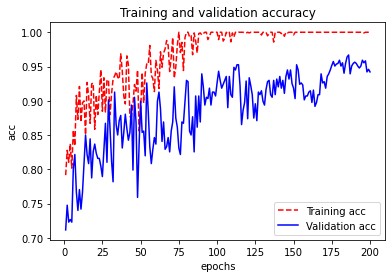

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = train_auc
val_acc = val_auc

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

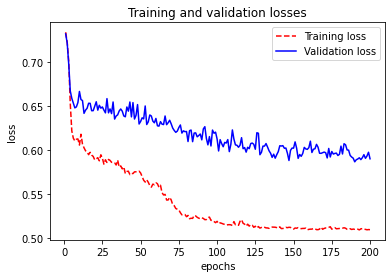

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = train_losses
val_acc = test_losses

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training loss'  )
plt.plot ( epochs, val_acc,  'b', label='Validation loss')
plt.title ('Training and validation losses')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [ ]:
accuracy_dataframe = pd.DataFrame({"train_auc":train_auc, "val_auc":val_auc})
accuracy_dataframe.to_csv("melanoma_without_duplicates_separated/AccuracyDataframe.csv", index=False)
losses_dataframe = pd.DataFrame({"train_auc":train_losses, "val_auc":test_losses})
losses_dataframe.to_csv("melanoma_without_duplicates_separated/LossesDataFrame.csv", index=False)

In [ ]:
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes) 
checkpoint = torch.load('melanoma_without_duplicates_separated/Pesos Resnet 20/resnet_weights_175.pt')
#checkpoint = torch.load('../input/pesos-melanoma/resnet_weights_60.pt',map_location ='cpu')

model.load_state_dict(checkpoint['state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_size = model.input_size 
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets) 
test_loader = dataloaders['test']

if torch.cuda.is_available(): model.cuda()
    
model.eval()

fn_list = [] 
pred_list = []

for inputs, features, fn in test_loader: 
    inputs = inputs.to(device) 
    features = features.to(device) 
    output = model(inputs, features) 
    pred = (output > 0).type(torch.float64) 
    #print(pred)
    fn_list += fn 
    pred_list += [p.item() for p in pred]

In [ ]:
submission = pd.DataFrame({"image_name":fn_list, "target":pred_list})
submission.to_csv("melanoma_without_duplicates_separated/Submission.csv", index=False)

In [ ]:
df_test = pd.read_csv("melanoma_without_duplicates_separated/test.csv")
df_merge = pd.merge(df_test, submission, left_index=True, right_index=True)

print("------------Matriz de confusión-------------------")
print(confusion_matrix(df_merge['target_x'], df_merge['target_y']))

print("------------Exactitud-------------------")
print(accuracy_score(df_merge['target_x'], df_merge['target_y']))

print("------------Precision-------------------")
print(precision_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(precision_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------Sensibilidad-------------------")
print(recall_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(recall_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------F1 score-------------------")
print(f1_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(f1_score(df_merge['target_x'], df_merge['target_y'], average=None))

------------Matriz de confusión-------------------
[[206  72]
 [ 22 241]]
------------Exactitud-------------------
0.8262476894639557
------------Precision-------------------
0.8385897154169698
[0.90350877 0.76996805]
------------Sensibilidad-------------------
0.8262476894639557
[0.74100719 0.91634981]
------------F1 score-------------------
0.8252044220635999
[0.81422925 0.83680556]
